<a href="https://colab.research.google.com/github/B4Farouk/smpl-dr-clip/blob/main/simpledCLIP_texture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import the GitHub Project

In [87]:
!rm -rf project #remove if it already exists 
!git clone https://github.com/B4Farouk/smpl-dr-clip project
!rm -rf sample_data

Cloning into 'project'...
remote: Enumerating objects: 587, done.
remote: Counting objects: 100% (253/253), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 587 (delta 139), reused 160 (delta 82), pack-reused 334
Receiving objects: 100% (587/587), 92.23 MiB | 16.98 MiB/s, done.
Resolving deltas: 100% (333/333), done.


### Install Dependencies
---
- pytorch (1.12.1)
- torchvision (0.13.1)
---
- pytorch3d
---
- SMPL
- chumpy

In [88]:
import os
import sys

In [89]:
# install torch
try:
    import torch
    if torch.__version__ != "1.12.1":
      raise ModuleNotFoundError()
except ModuleNotFoundError:
    !pip install torch==1.12.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [90]:
# install torchvision
try:
    import torchvision
    if torchvision.__version__ != "0.13.1":
      raise ModuleNotFoundError()
except ModuleNotFoundError:
    !pip install torchvision==0.13.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [91]:
# install pytorch3d
import torch, torchvision

try:
    import pytorch3d
except ModuleNotFoundError:
    if torch.__version__.startswith("1.12.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install pytorch3d

In [92]:
# install SMPL dependencies
!pip install smplpytorch
!pip install chumpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [93]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
! pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-oxe03upw
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-oxe03upw
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### GPU

In [94]:
torch.cuda.is_available()

True

In [95]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [96]:
# GPU or CPU
gpu, cpu = None, None
if torch.cuda.is_available():
    gpu = torch.device("cuda:0")
    torch.cuda.set_device(gpu)
else:
    cpu = torch.device("cpu")
dev = gpu if gpu is not None else cpu
dev

device(type='cuda', index=0)

### Local Imports 

In [97]:
import clip
import trimesh
from project.smpl import SMPLwrapper, mesh_from
from project.textures import TexturesFactory
from project.rendering import CamerasFactory, Renderer
from project.clipwrapper import CLIPwrapper

from project.optimization import OptimEnv, init_weights
from project.model import compose, SimpledCLIPContext


from project.plots import *

from project.metrics import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### SMPL

In [98]:
# initalize a textures factory
txfactory = TexturesFactory(device=dev)
colored_reference_SMPL = trimesh.load("project/SMPL_female_with_colors.obj", process=False)
# use the texture factory to create a texture generator: a function that takes faces and creates a texture
def texture_generator(vert,faces):
  return txfactory.from_image(colored_reference_SMPL ,vert,faces )
# pose and shape initalization
pose_vect = torch.zeros((1, 72), device=dev) # theta, used in optimization
shape_vect = torch.ones((1, 10), device=dev) # beta, not used in optimization
# create the smpl model
smpl_model = SMPLwrapper(model=None, txmapping=texture_generator, device=dev) #model=None uses the default model
# create the mesh
mesh = smpl_model.mesh(theta=pose_vect, beta=shape_vect)

### Differentiable Renderer

In [99]:
# create a cameras factory
camsfactory = CamerasFactory(device=dev)
# create a camera using the cameras factory
camera = camsfactory.fov_persp_scs(coords=(2.25, 0, 3), fov=60, frustrum_depth=(1, 100))
# create a renderer
renderer = Renderer(device=dev, cameras=camera)
# render the textured mesh generated by SMPL
image = renderer.render(mesh)

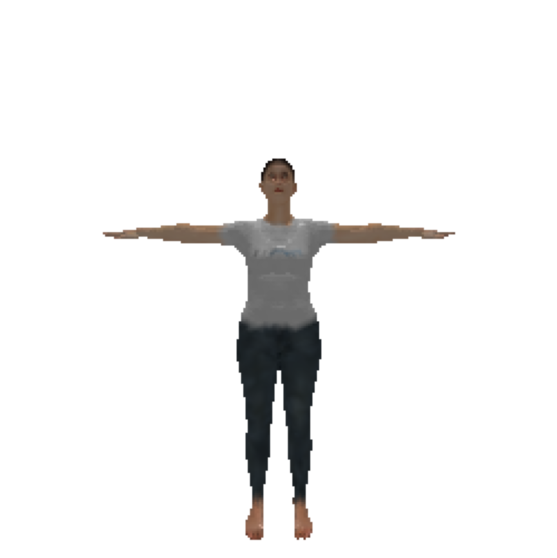

In [100]:
# a quick visualization of the rendered mesh
plot_image_t(image);

### CLIP

In [101]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [102]:
clip_model = CLIPwrapper(model_name="ViT-B/32", device=dev)

In [103]:
def info_str(tensor):
    print("### tensor info:")
    print("shape: " + str(tensor.shape))
    print("device: " + str(tensor.get_device()))
    print("requires grad: " + str(tensor.requires_grad))
    print("### end of tensor info\n")

In [104]:
cos_dist(clip_model.img_emb(image), clip_model.pmt_emb("""
a brown mannequin in a white background. The mannequin is looking upfront. The mannequin is standing up on his feet. Both the mannequin's hands are up.""")).item()

0.669921875

### MODELS


In [105]:
# set clip in training mode
clip_model.train()

# create a model factory
model_context = SimpledCLIPContext(smpl_model, renderer, clip_model) 
MODELS = {
    "P1": model_context.create(
        prompt="""a brown mannequin in a white background. The mannequin is looking upfront. The mannequin is standing up on his feet. Both the mannequin's hands are up."""),
    "P2": model_context.create(
        prompt="""a brown mannequin in a white background. The mannequin is lying on the ground. The mannequin's hands are on its hips"""),
    "P3": model_context.create(
        prompt="""a brown mannequin in a white background. The mannequin is falling on its back.""")
}

In [106]:
cos_dist(clip_model.img_emb(image), clip_model.pmt_emb("a brown mannequin in space"))

tensor([0.7305], device='cuda:0', dtype=torch.float16, grad_fn=<RsubBackward1>)

In [107]:
def run_optimization(model, n_passes=1000):
  pose, shape = init_weights(device=dev) # weights used in optimization
  optimenv = OptimEnv(model=model, params=[pose, shape], lr=1e-3) # we do not optimize with respect to the shape
  result = optimenv.optimize(pose=pose, shape=shape, n_passes=n_passes, tracker_settings={"loss":{"interleaving": 10}, "pose": {"interleaving": 100}, "shape": {"interleaving": 100}})
  return result

def intermediate_views(result, coords):
  camera = camsfactory.fov_persp_scs(coords=coords, fov=60, frustrum_depth=(1, 100))
  renderer = Renderer(device=dev, cameras=camera)
  pose_shape = zip(result["tracked"]["poses"]["pose"], result["tracked"]["shapes"]["shape"])
  for pose, shape in pose_shape:
    pose, shape = pose.to(dev), shape.to(dev)
    mesh = smpl_model.mesh(theta=pose, beta=shape)
    image = renderer.render(mesh)
    plot_image_t(image)

In [108]:
result = run_optimization(MODELS["P1"])

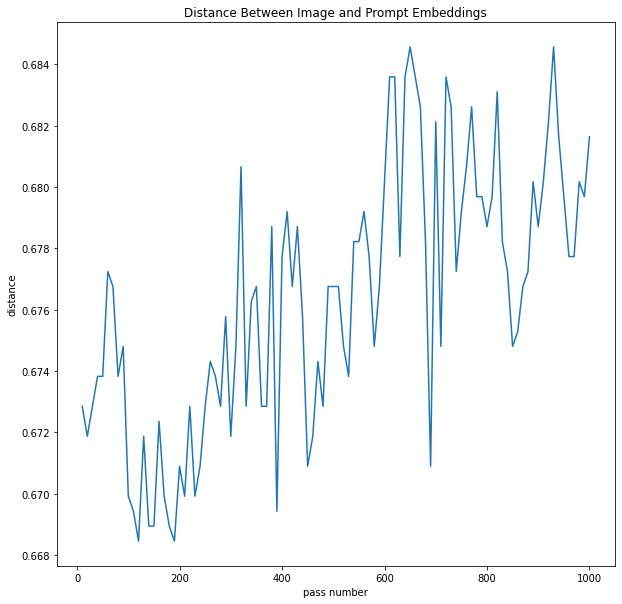

In [109]:
plot_losses(result["tracked"]["losses"])

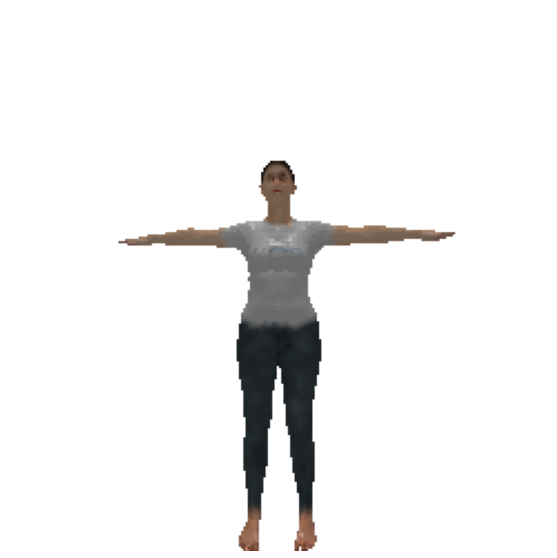

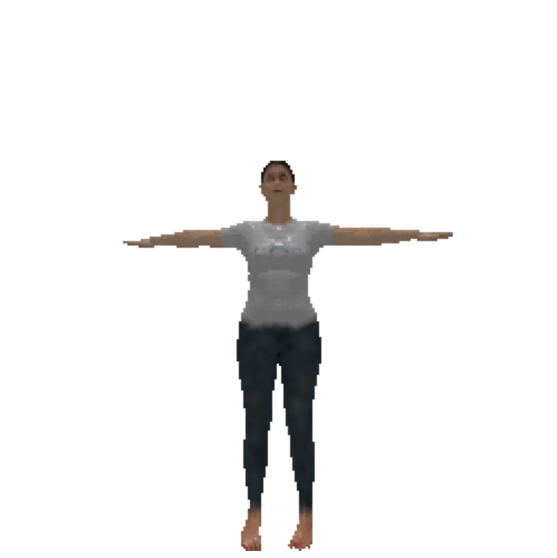

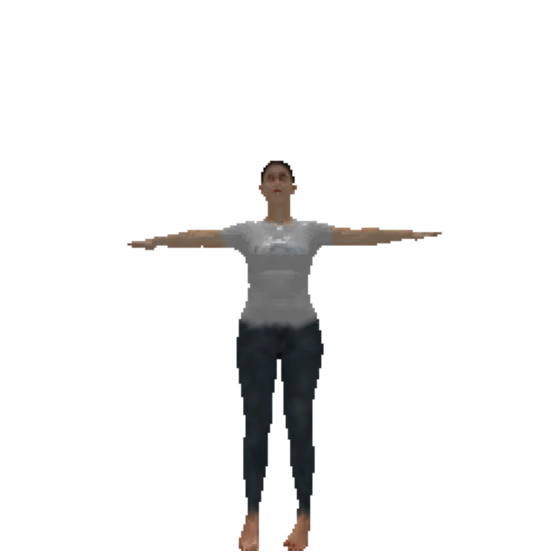

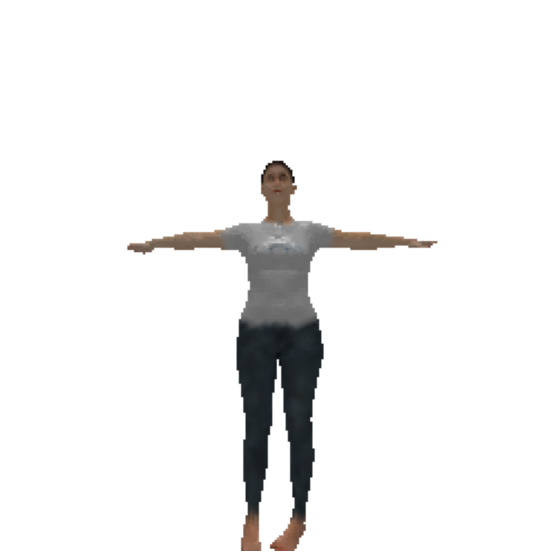

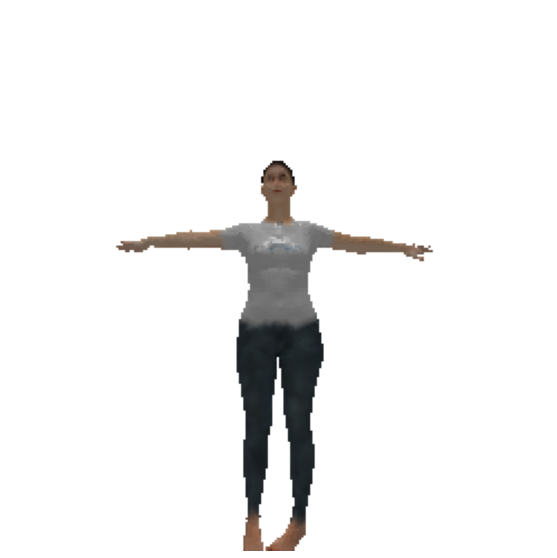

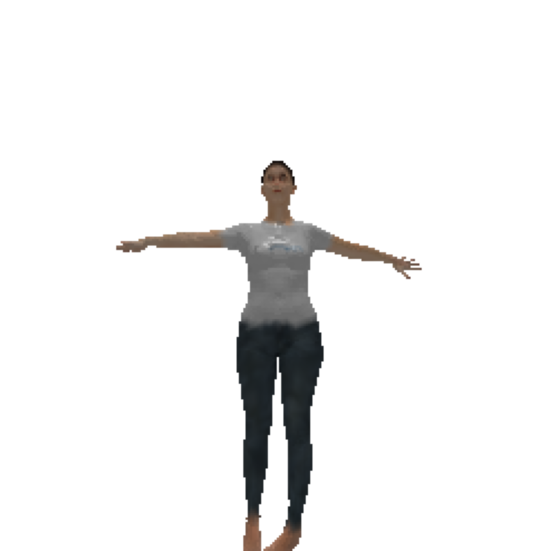

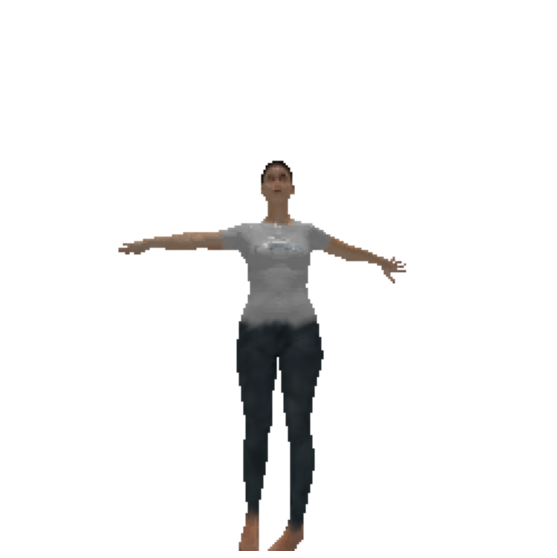

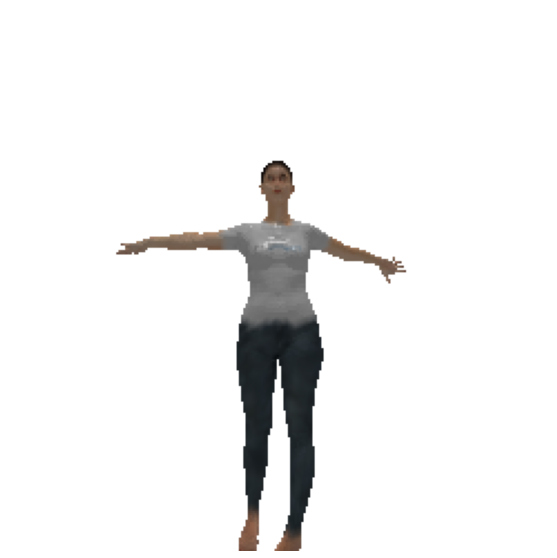

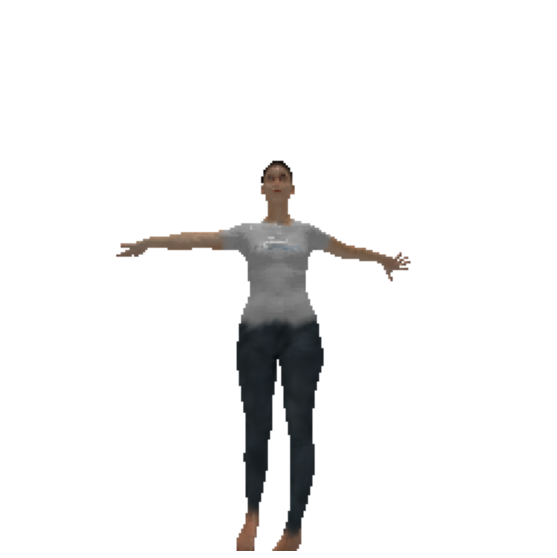

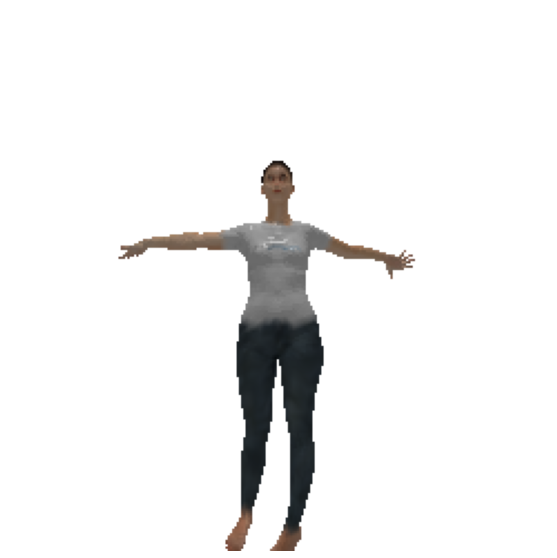

In [110]:
intermediate_views(result, coords=(2.25, 0, 3))

In [111]:
result2 = run_optimization(MODELS["P1"], n_passes=5000)

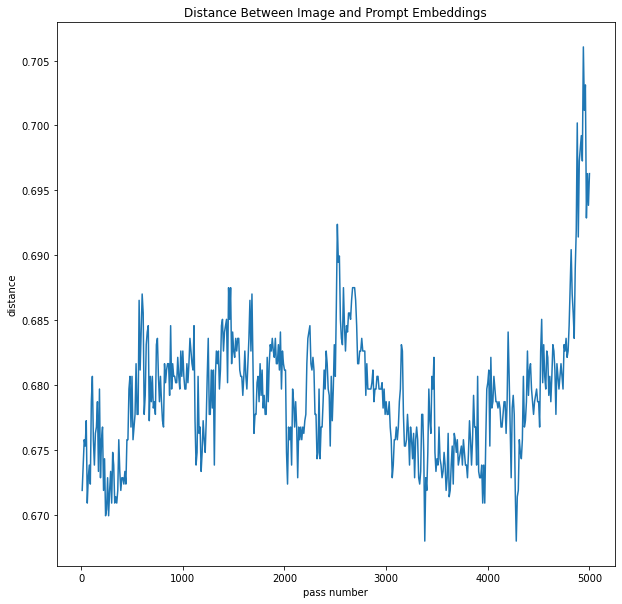

In [112]:
plot_losses(result2["tracked"]["losses"])

/content/project/plots.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, 1, figsize=(10,10))


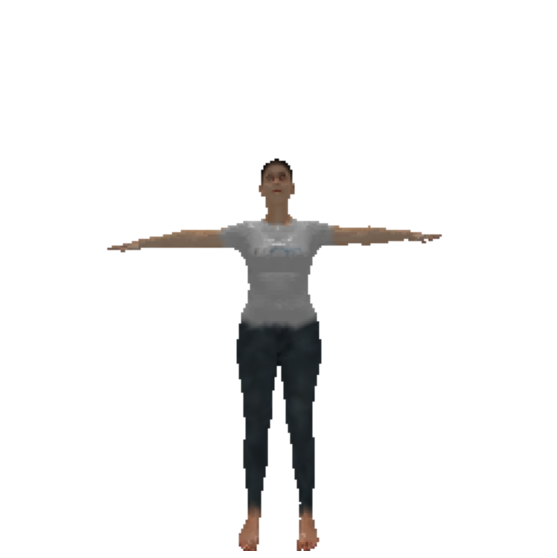

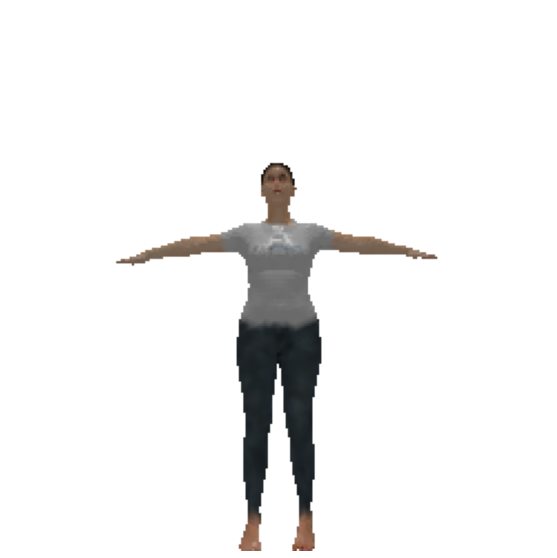

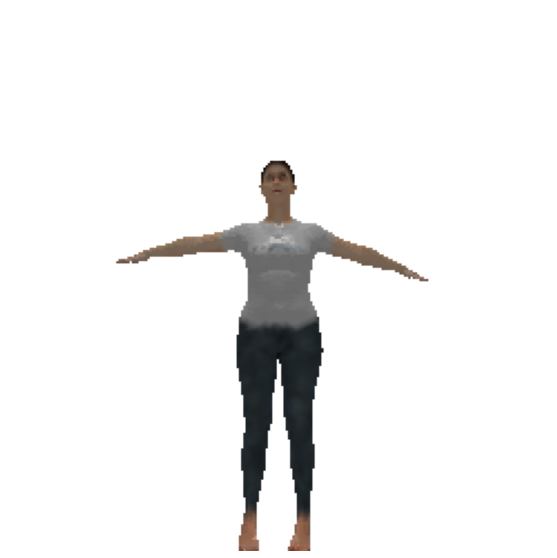

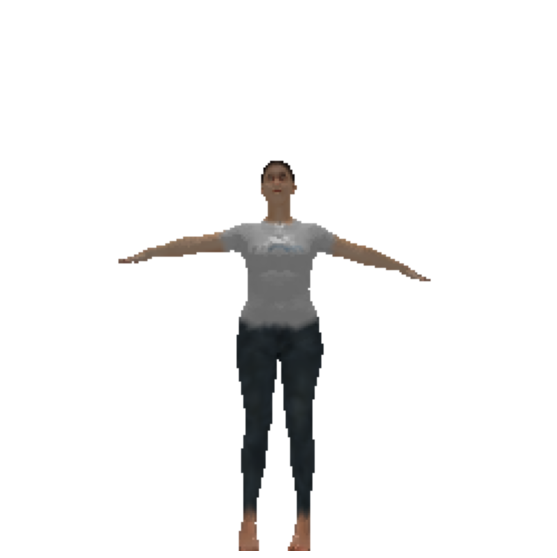

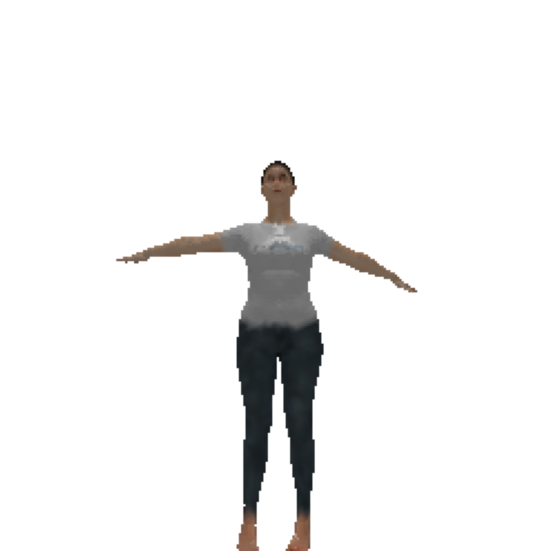

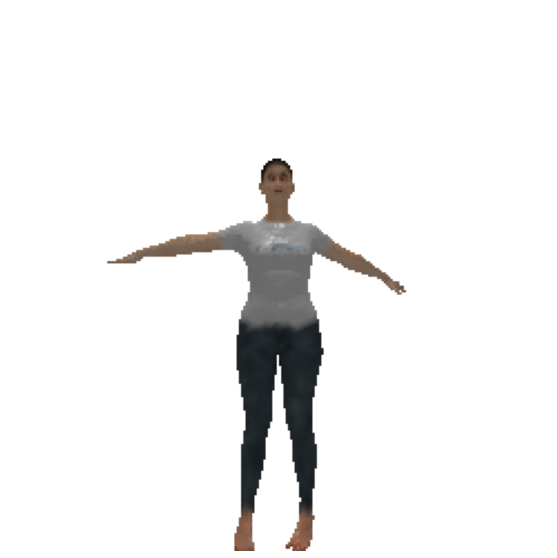

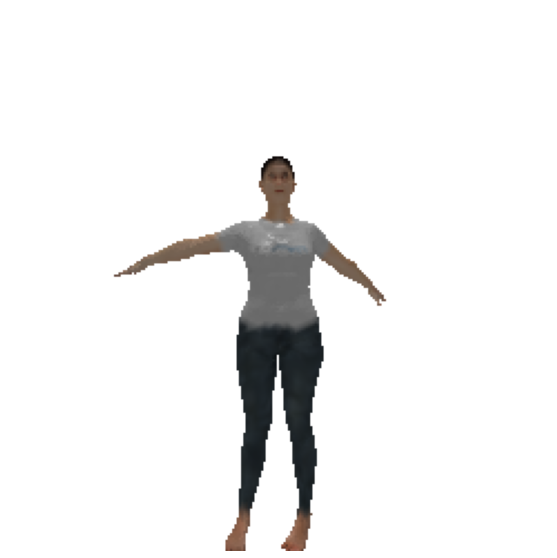

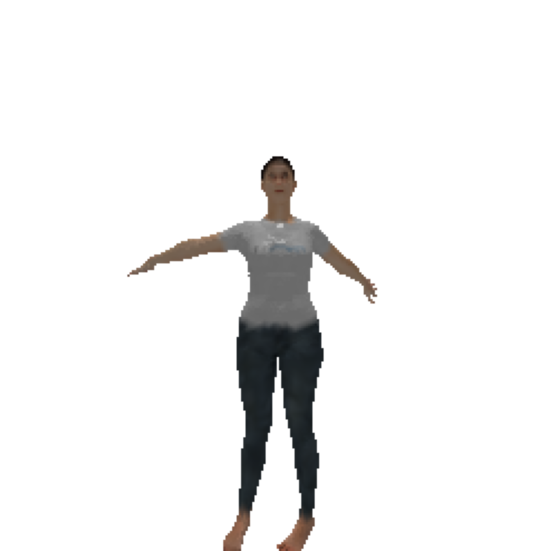

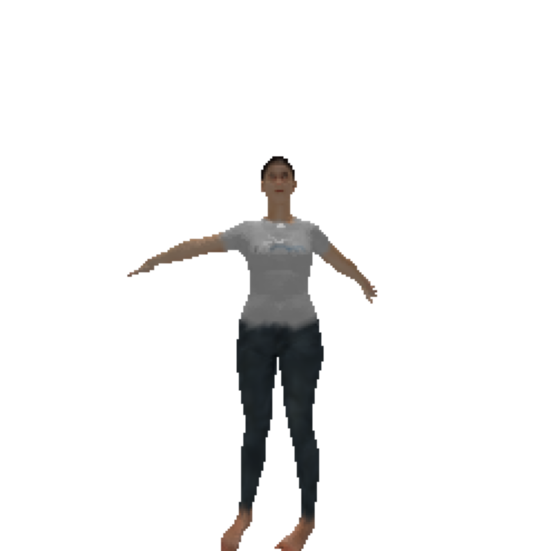

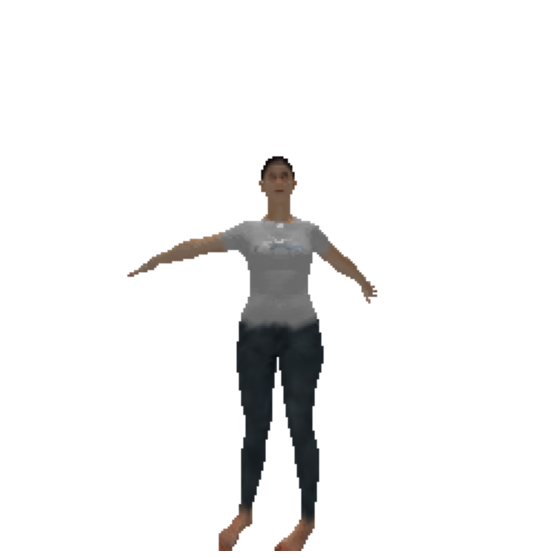

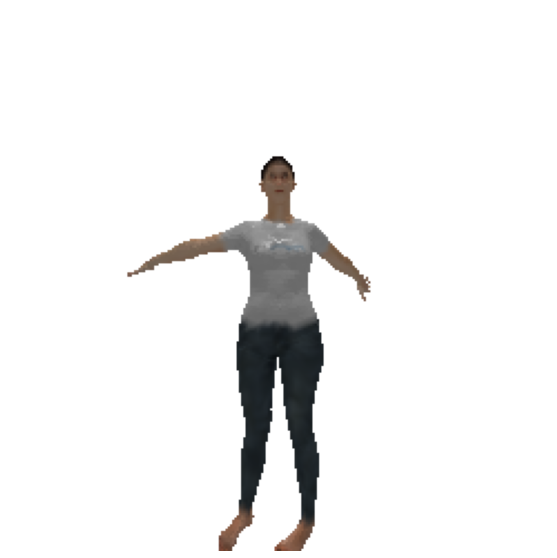

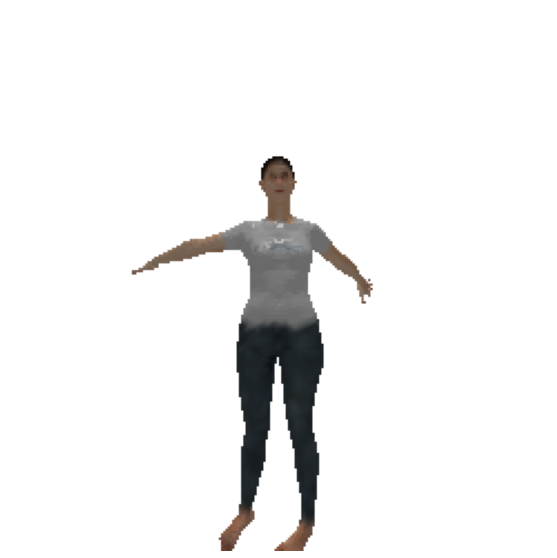

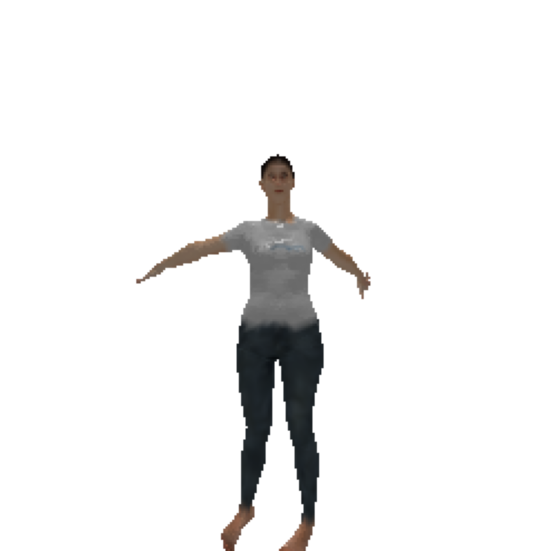

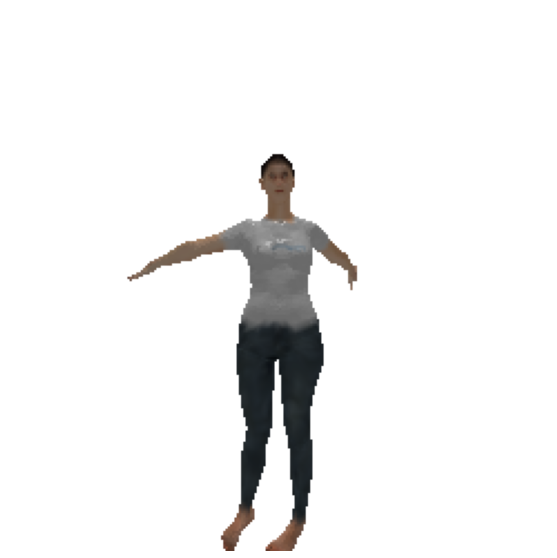

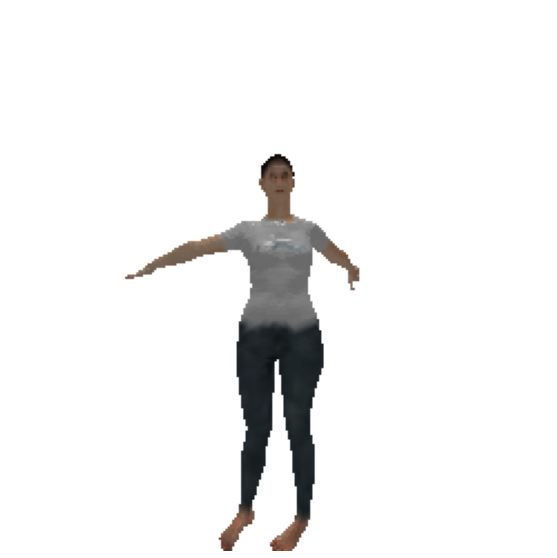

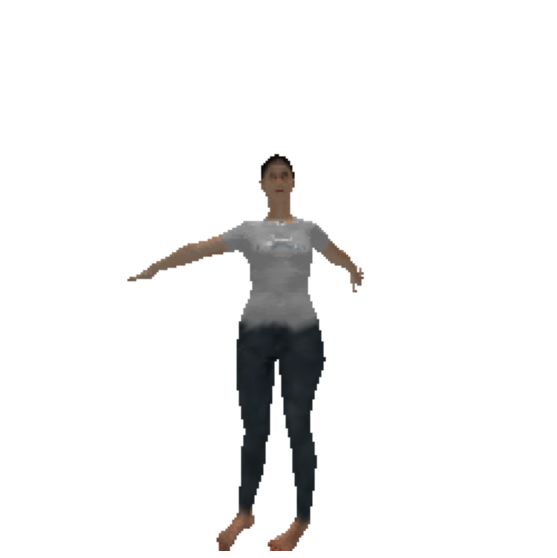

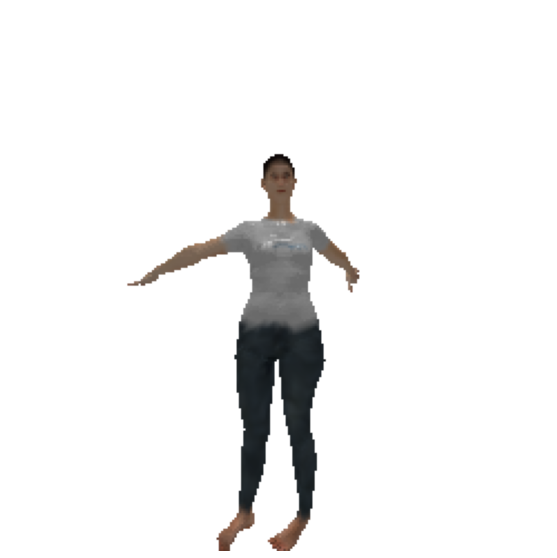

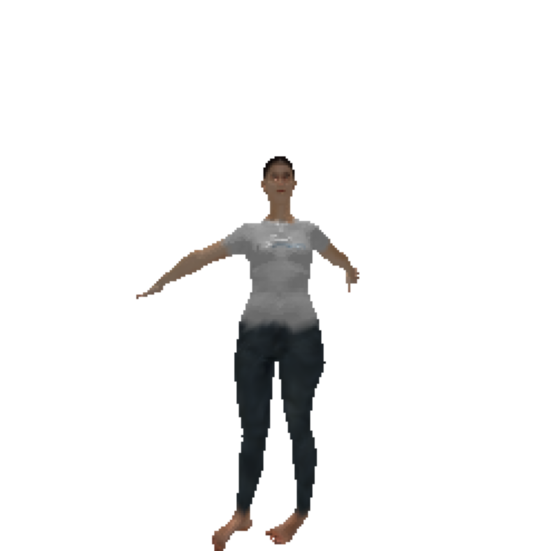

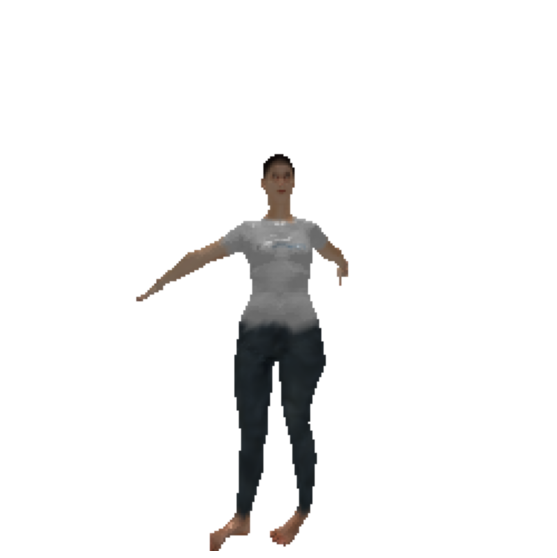

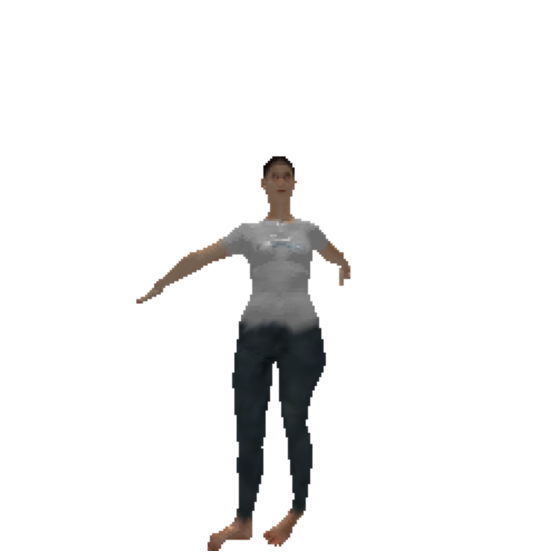

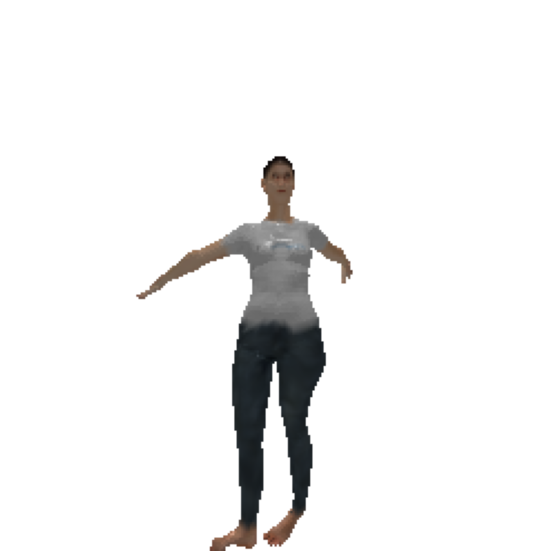

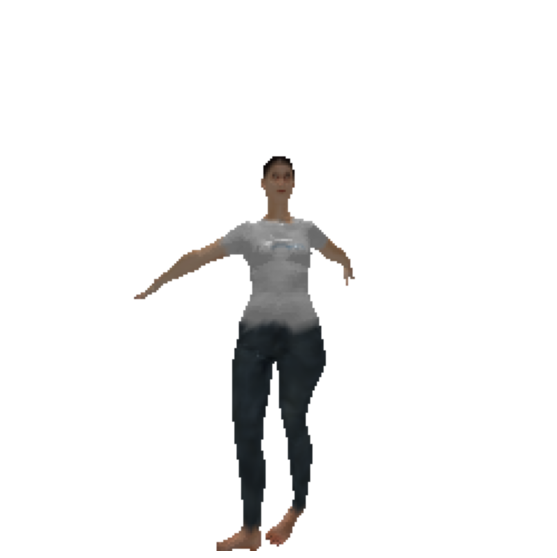

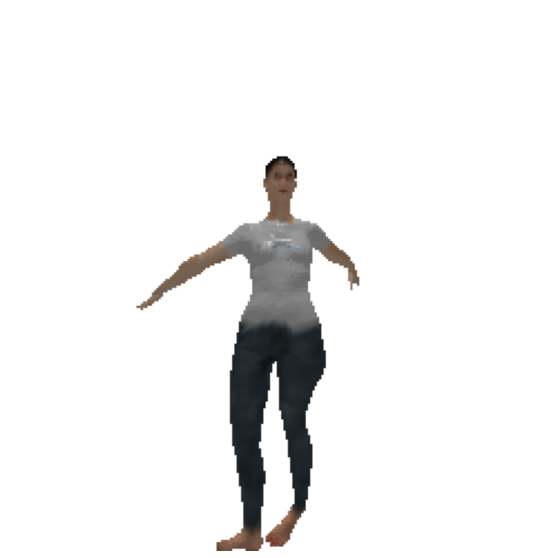

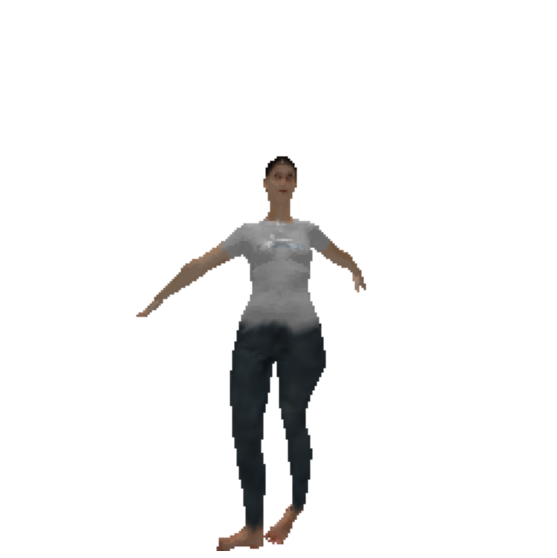

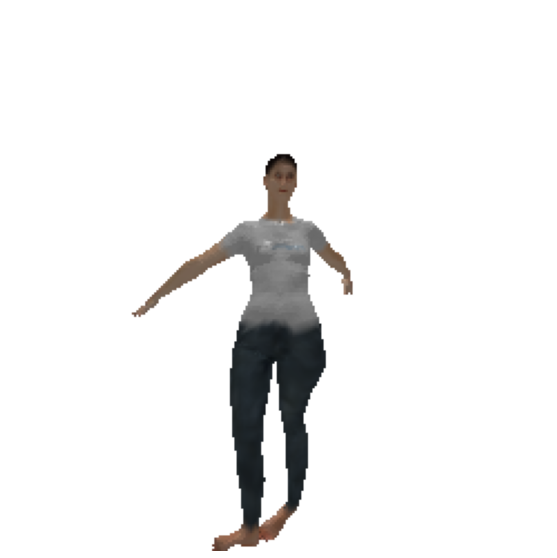

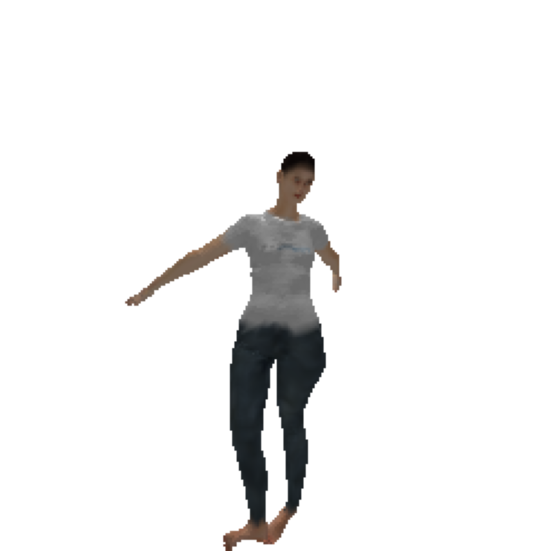

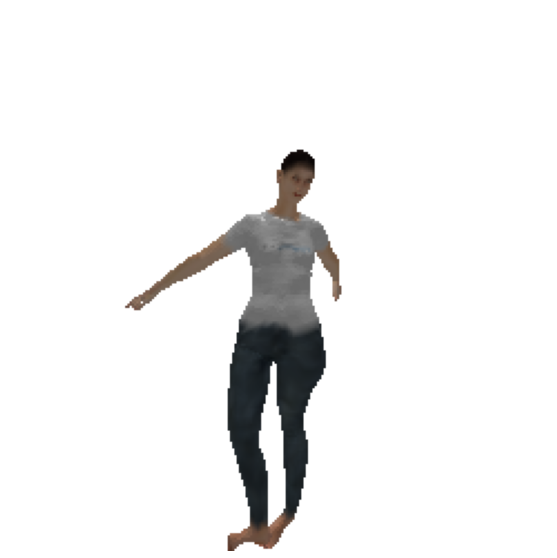

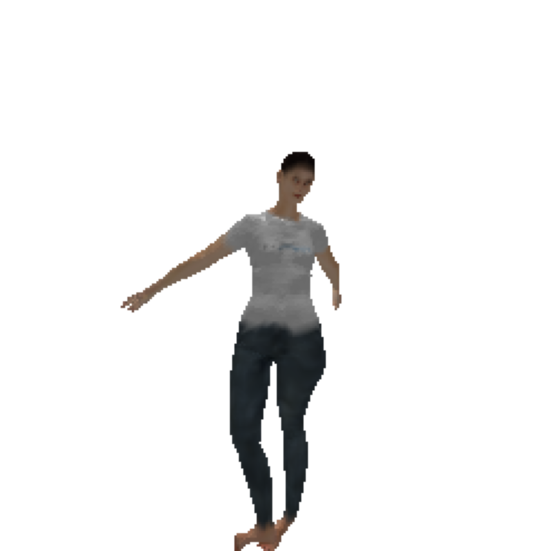

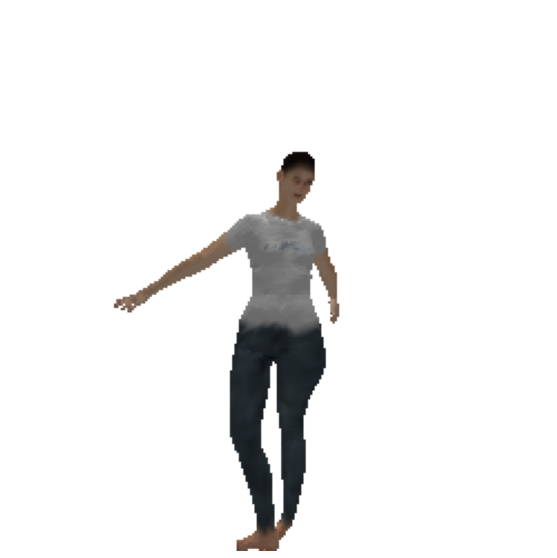

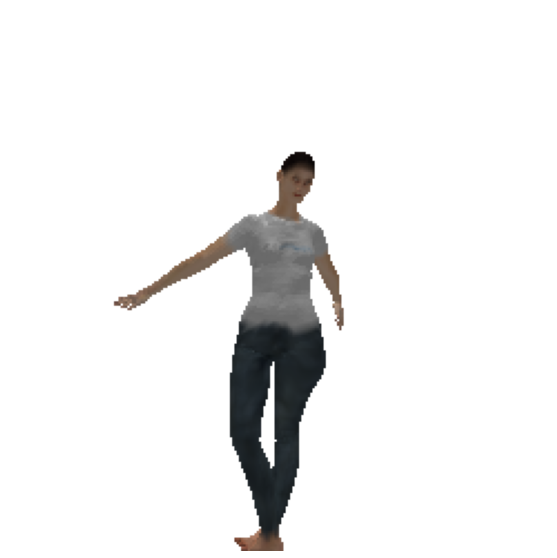

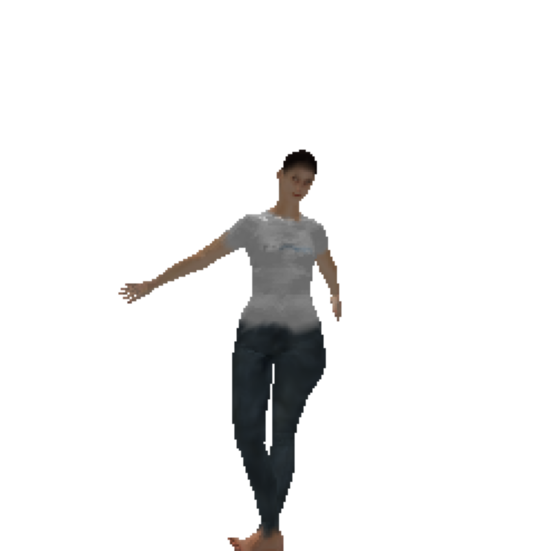

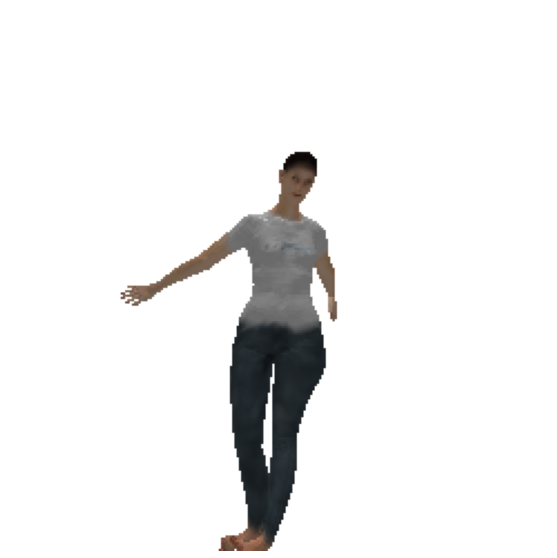

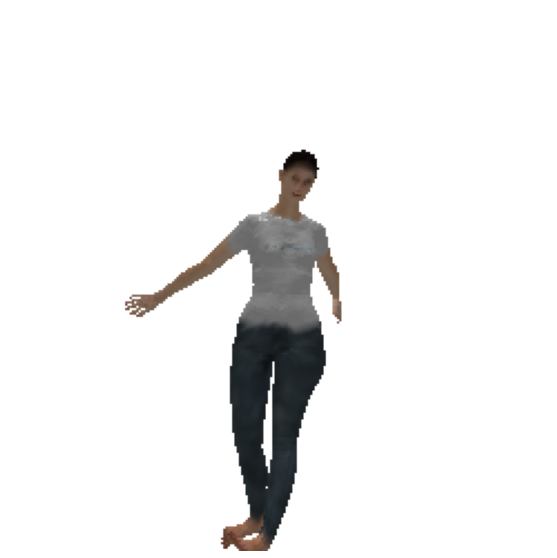

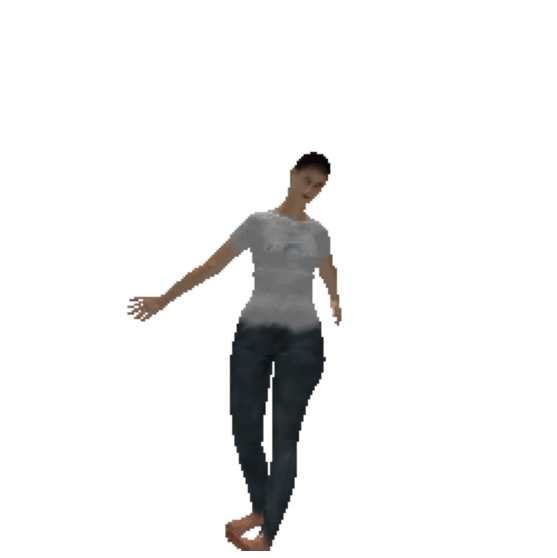

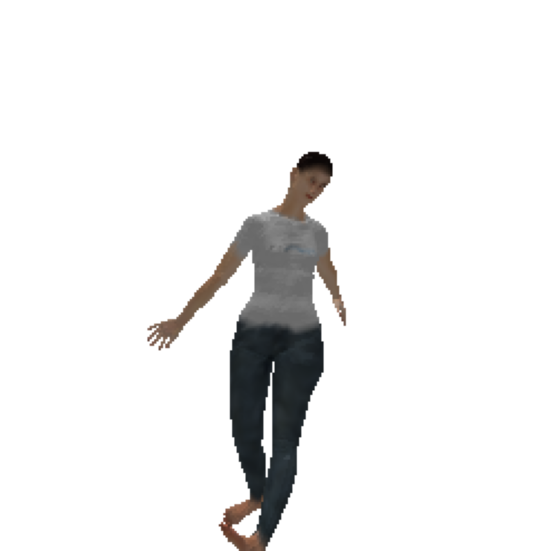

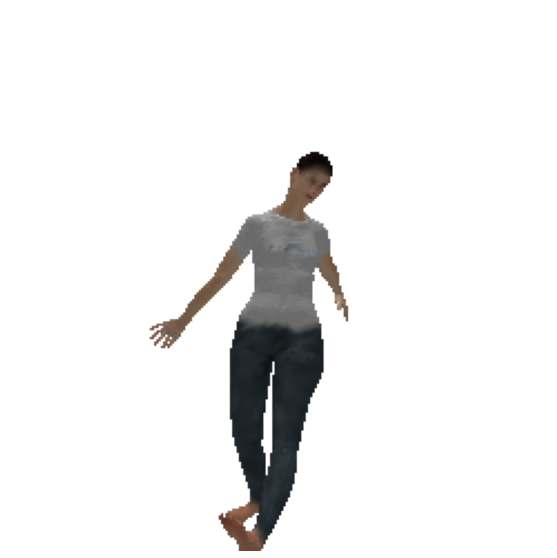

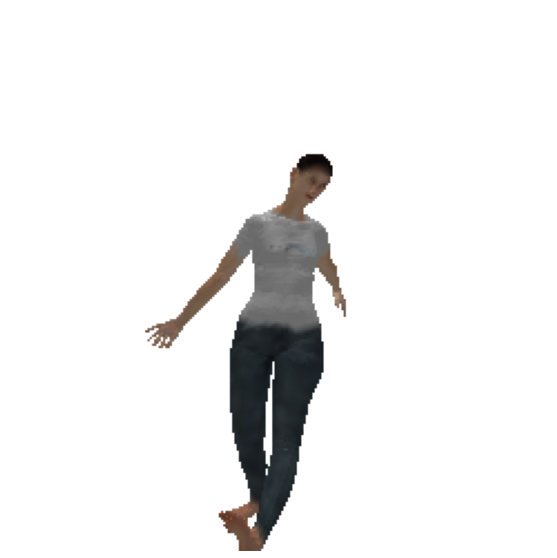

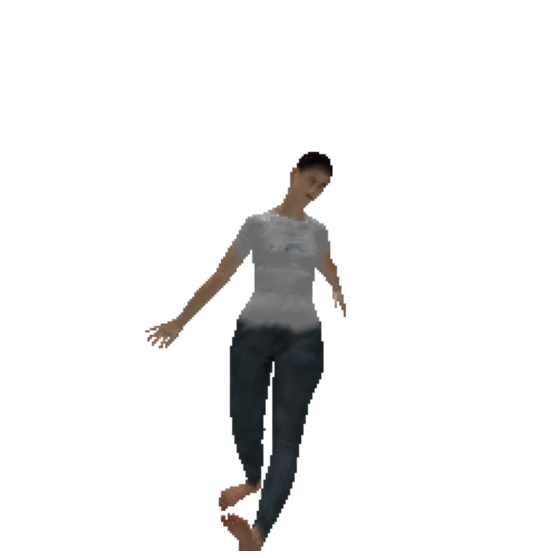

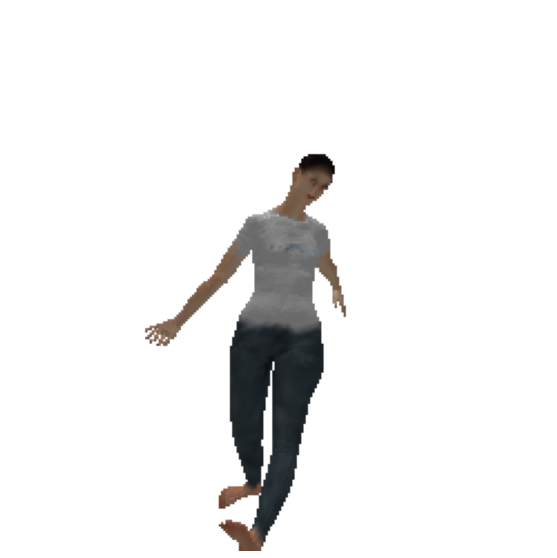

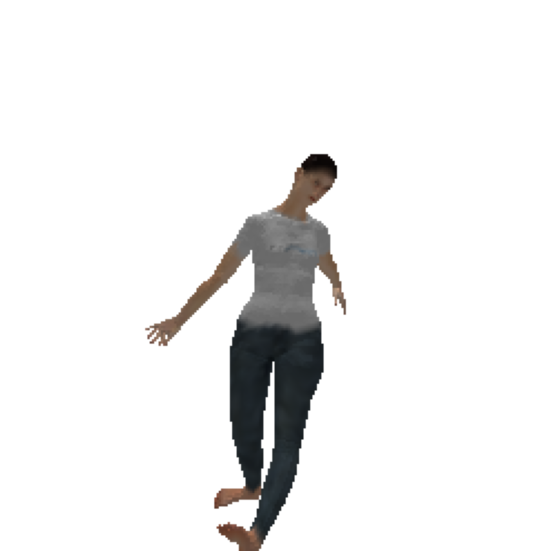

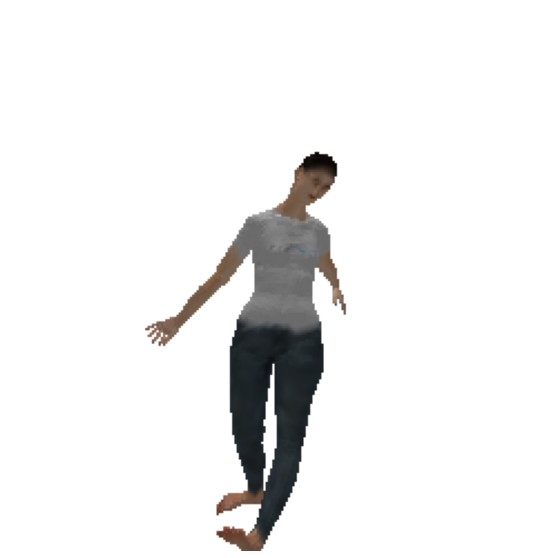

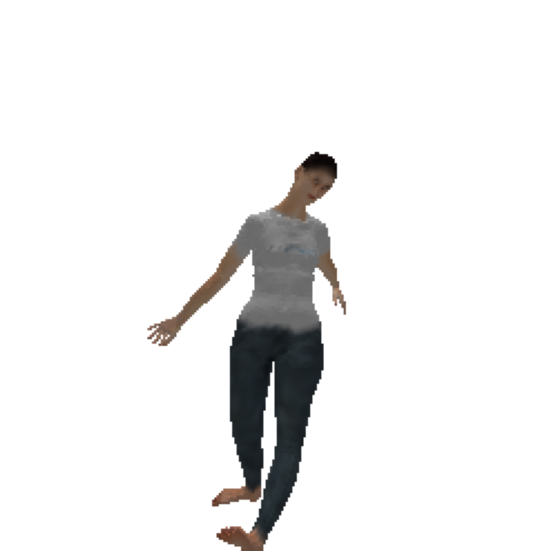

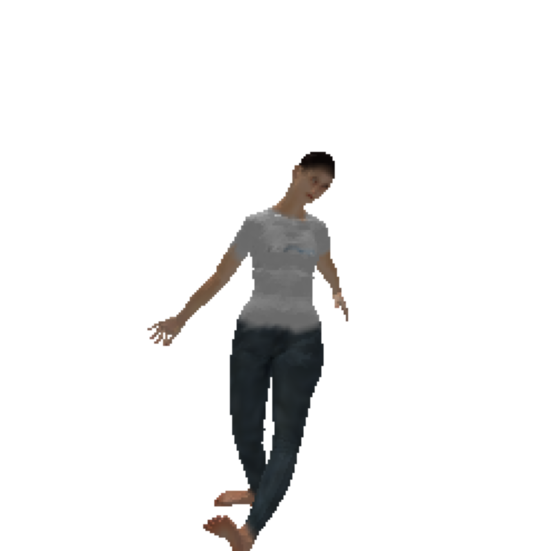

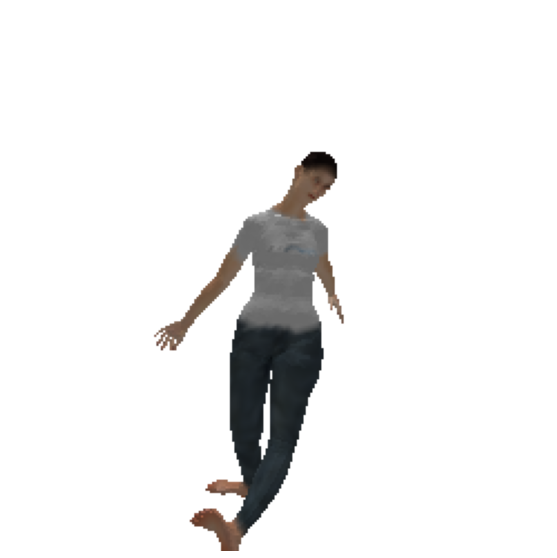

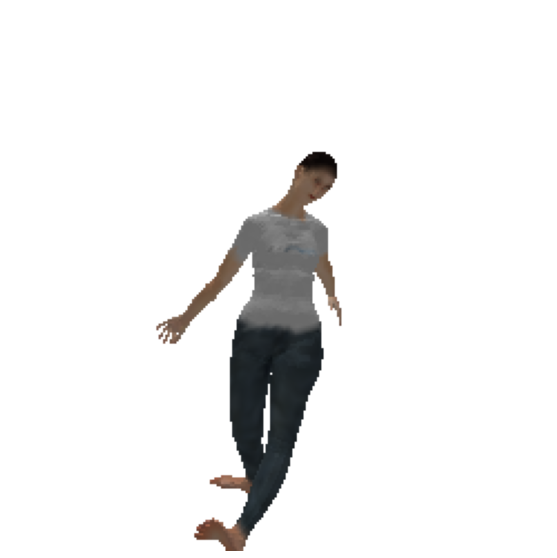

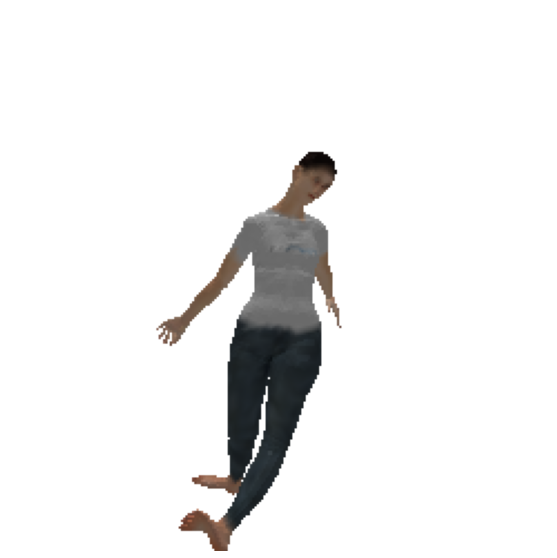

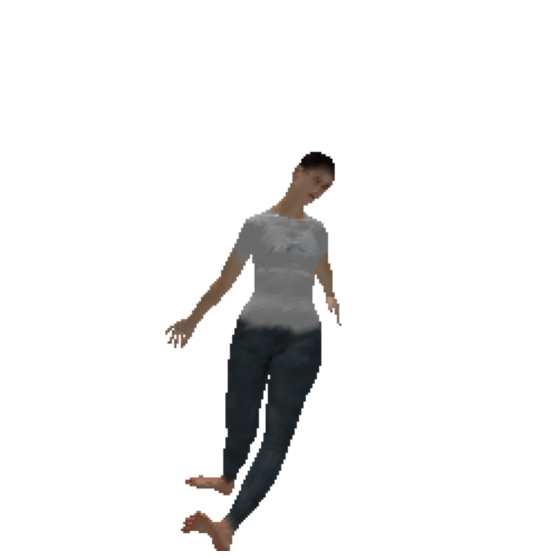

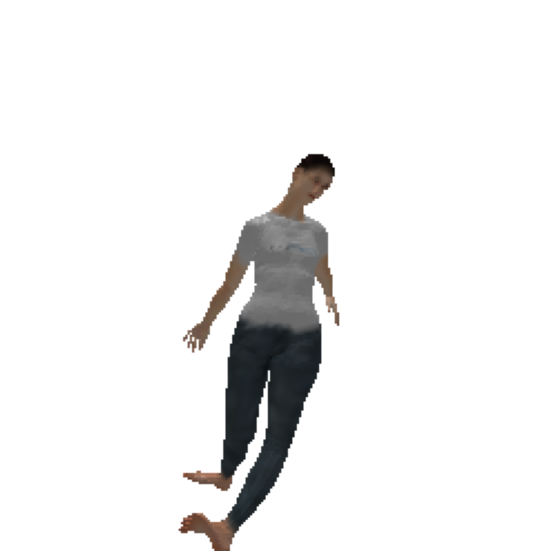

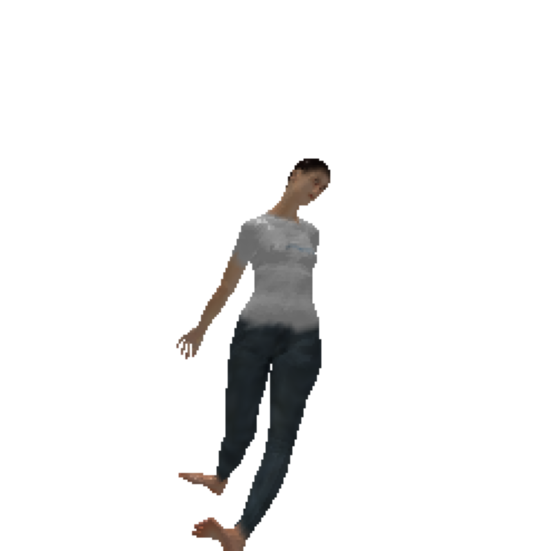

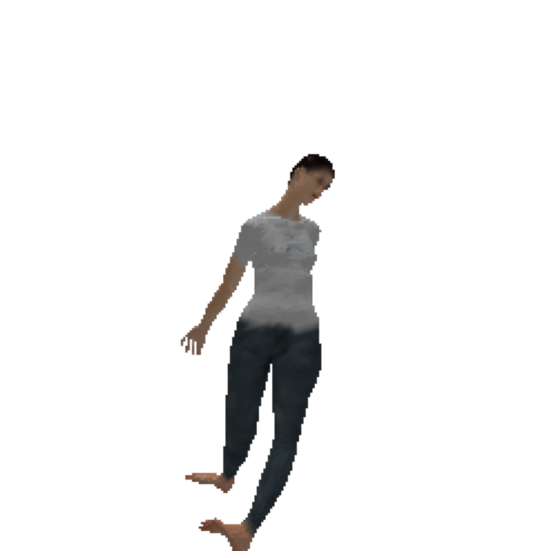

In [113]:
intermediate_views(result2, coords=(2.25, 0, 3))